In [18]:
%pylab inline
import matplotlib.pyplot as plt
import PIL
import numpy as np
from glob import glob
from scipy.cluster.vq import kmeans

Populating the interactive namespace from numpy and matplotlib


/Users/daryabaranovskaya/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Первый способ

Первый способ является самым примитивным. Суть здесь в следующем: каждый пиксель окрашивается в тот из двух цветов, на котороый он больше похож, к которому он ближе (рассотяние считаем как евклидову метрику)

In [19]:
def dist(c1, c2):
    return ((c1 - c2)**2).sum()

In [20]:
def apply_cut(img, classes, centers):
    assert len(centers) == 2
    result = img.copy()
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            result[x][y] = centers[classes[x][y]]
    result = np.clip(result, 0, 255)
    return result

In [21]:
def process_img(img_file, cut_func, centers, show=False):
    img = np.array(PIL.Image.open(img_file))[:, :, :3].astype('int64')

    centers = np.array(centers)
    classes = cut_func(img, centers)
    clustered = apply_cut(img, classes, centers)
    
    if show:
        fig = plt.figure(figsize=(16, 8))
        fig.add_subplot(1, 2, 1)
        plt.imshow(img)

        fig.add_subplot(1, 2, 2)
        plt.imshow(clustered)
        plt.show()

In [22]:
def simple_get_centers(img_file):
    img = np.array(PIL.Image.open(img_file))[:, :, :3].astype('float').reshape((-1, 3))
    return kmeans(img.astype('float'), 2)[0].astype('int64')

In [23]:
def simple_cut(img, centers):
    assert len(centers) == 2
    classes = np.zeros_like(img[:, :, 0])
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if dist(img[x][y], centers[0]) < dist(img[x][y], centers[1]):
                classes[x][y] = 0
            else:
                classes[x][y] = 1
    return classes

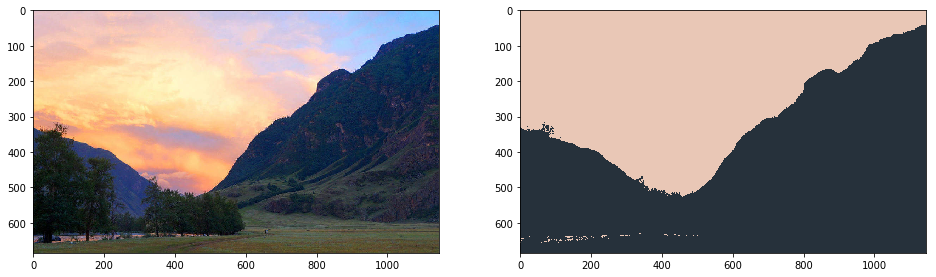

In [12]:
img = 'testimage.jpg'
c = simple_get_centers(img)
process_img(img, simple_cut, c, True)

### Второй способ

Здесь окраска каждого пикселя зависит не только от его расстояния до двух главных цветов (цвета центров классов), но и от цвета соседних с ним пикселей.

Вводится следующая система штрафов: штрафы за отнесение пикселя к тому или иному главному цвету, который прапорционален евклидовому расстоянию и штрафы за отнесение двух соседних пикселей к разным главным цветам, чем меньше похожи два соседних пикселя, тем меньше штраф за отнесение их к разным сегментам. 

Далее сопоставляем нашей картинке ориентиарованный граф, где каждому пикселю соответствует вершина графа. Добавляются вершины соответствующие центрам классов. Из первого центра во все вершины картинки проводятся ребра, вес которых равен штрафу за отнесении текущего пикселя к первому цвету. Из всех вершин картинки проводятся ребра в вершину второго центра с весом равному штрафу за отнесение текущего пикселя к цвету второго центра. Для каждого пикселя проводим ребра из него в его соседние пиксели с весом равным штрафу за  отнесение двух соседних пикселей к разным главным цветам. Далее строится минимальный разрез, в котором вершины центра должны быть по разные стороны от разреза, и полученные два множества и будут нашим ответом для двух цветов. Все множество, содержащее первый центр окрашивается в первый цвет, второе - во второй.

Первый код строит минимальный разрез графа с помощью библиотечной функции nx.minimum_cut() второй - с помощью 

In [24]:
import networkx as nx
import math

#### First

In [25]:
def cut2NXMincut(img, centers):
    assert len(centers) == 2
    classes = np.zeros_like(img[:, :, 0])
    G = nx.DiGraph()
    s = (tuple(centers[0]), -1, -1)
    t = (tuple(centers[1]), img.shape[0], img.shape[1])
    G.add_node(s)
    G.add_node(t)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            a = (tuple(img[x][y]), x, y)
            G.add_node(a)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            r1 = (tuple(img[x][y]), x, y)
            if(x != 0):
                r2 = (tuple(img[x - 1][y]), x-1, y)
                weightt = (1 + sqrt((r1[0][0] - r2[0][0])**2 + (r1[0][1] - r2[0][1])**2 + (r1[0][2] - r2[0][2])**2)) / 255
                G.add_edge(r1, r2, capacity = weightt)
            if(y != 0):
                r2 = (tuple(img[x][y - 1]), x, y - 1)
                weightt = (1 + sqrt((r1[0][0] - r2[0][0])**2 + (r1[0][1] - r2[0][1])**2 + (r1[0][2] - r2[0][2])**2)) / 255
                G.add_edge(r1, r2, capacity = weightt)
            if(x != img.shape[0] - 1):
                r2 = (tuple(img[x + 1][y]), x+1, y)
                weightt = (1 + sqrt((r1[0][0] - r2[0][0])**2 + (r1[0][1] - r2[0][1])**2 + (r1[0][2] - r2[0][2])**2)) / 255
                G.add_edge(r1, r2, capacity = weightt)
            if(y != img.shape[1] - 1):
                r2 = (tuple(img[x][y + 1]), x, y+1)
                weightt = (1 + sqrt((r1[0][0] - r2[0][0])**2 + (r1[0][1] - r2[0][1])**2 + (r1[0][2] - r2[0][2])**2)) / 255
                G.add_edge(r1, r2, capacity = weightt)
            weightt = sqrt((r1[0][0] - s[0][0])**2 + (r1[0][1] - s[0][1])**2 + (r1[0][2] - s[0][2])**2)
            G.add_edge(s, r1, capacity = weightt)
            weightt = sqrt((r1[0][0] - t[0][0])**2 + (r1[0][1] - t[0][1])**2 + (r1[0][2] - t[0][2])**2)
            G.add_edge(r1, t, capacity = weightt)
    penalty, pursing = nx.minimum_cut(G, s, t)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            a = (tuple(img[x][y]), x, y)
            if (a in pursing[0]):
                classes[x][y] = 1
            else:
                classes[x][y] = 0
    return penalty, classes

In [26]:
def process2_img(img_file, cut_func, centers, show=False):
    img = np.array(PIL.Image.open(img_file))[:, :, :3].astype('int64')

    centers = np.array(centers)
    penalty, classes = cut_func(img, centers)
    clustered = apply_cut(img, classes, centers)
    
    if show:
        fig = plt.figure(figsize=(16, 8))
        fig.add_subplot(1, 2, 1)
        plt.imshow(img)

        fig.add_subplot(1, 2, 2)
        plt.imshow(clustered)
        plt.show()

    return penalty

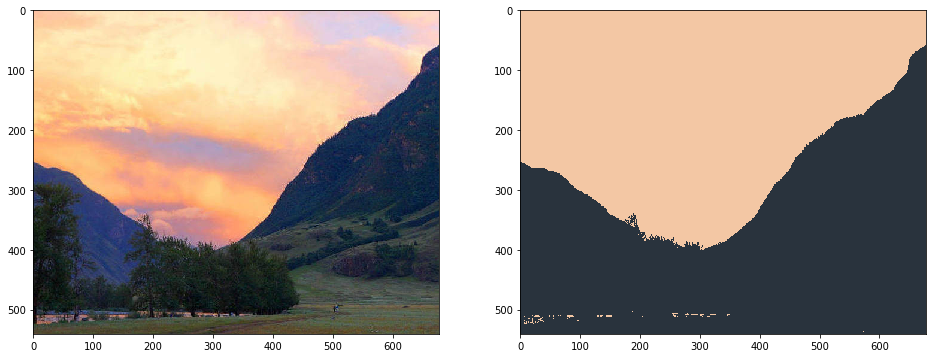

14850053.071169542

In [10]:
img = 'testimageCutted.jpg'
c = simple_get_centers(img)
process2_img(img, cut2NXMincut, c, True)

#### Second

In [27]:
def BFS(graph, path, s, t):
    used = [False for i in range (len(graph))]
    queue = []
    queue.append(s)
    used[s] = True
    while (queue):
        cur = queue[0]
        queue.pop(0)
        for neighbour in range (len(graph)):
            if (graph[cur][neighbour] > 0):
                if (not used[neighbour]):
                    used[neighbour] = True
                    path[neighbour] = cur
                    queue.append(neighbour)    
    return True if used[t] else False

In [28]:
def min_cut(graph, source, sink):
    copy_graph = graph.copy()
    path = [-1] * (len(graph))
    max_flow = 0
    while BFS(graph, path, source, sink): 
        path_flow = float("Inf") 
        x = sink 
        while(x != source): 
            path_flow = min(path_flow, copy_graph[path[x]][x]) 
            x = path[x] 
        max_flow += path_flow 
        y = sink 
        while(y != source): 
            z = path[y] 
            copy_graph[z][y] -= path_flow 
            copy_graph[y][z] += path_flow 
            y = path[y] 
    return max_flow, copy_graph

In [29]:
def components(x, y): # первая формула для подсчёта штрафа -- отнесение пикселя к классу
    result = sqrt(((x - y)**2).sum())
    return result

In [30]:
def edges(x, y): # вторая формула для подсчёта штрафа -- разбиение соседей по разным классам
    result = 1 / (1 + (sqrt(((x - y)**2).sum())) / 255)
    return result

In [31]:
def cut_funcMinCut(img, centers):
    assert len(centers) == 2
    size1 = img.shape[0]
    size2 = img.shape[1]
    G = [[0 for j in range (size1 * size2 + 2)] for i in range (size1 * size2 + 2)]
    s = size1 * size2
    t = size1 * size2 + 1
    pixel_place = {}
    place_pixel = {}
    i = 0
    for x in range (size1):
        for y in range (size2):
            place_pixel[i] = (x, y)
            pixel_place[(x, y)] = i
            i += 1
    for x in range(size1):
        for y in range(size2):
            if (x != 0):
                G[pixel_place[(x, y)]][pixel_place[(x - 1, y)]] = edges(img[x][y], img[x - 1][y])
            if (x != size1 - 1):
                G[pixel_place[(x, y)]][pixel_place[(x + 1, y)]] = edges(img[x][y], img[x + 1][y])
            if (y != 0):
                G[pixel_place[(x, y)]][pixel_place[(x, y - 1)]] = edges(img[x][y], img[x][y - 1])
            if (y != size2 - 1):
                G[pixel_place[(x, y)]][pixel_place[(x, y + 1)]] = edges(img[x][y], img[x][y + 1])
            G[s][pixel_place[(x, y)]] = components(img[x][y], centers[0])
            G[pixel_place[(x, y)]][t] = components(img[x][y], centers[1])
    classes_sum, copy_graph = min_cut(G, s, t)
    classes = [[0 for x in range (size2)] for y in range (size1)]
    for i in range(len(G) - 2):
        parent = [-1] * (len(G))
        if (BFS(copy_graph, parent, s, i)):
            classes[place_pixel[i][0]][place_pixel[i][1]] = 1
    return classes_sum, classes



In [32]:
def process2_imgChangeResolution(img_file, cut_func, centers, show=False):
    im = PIL.Image.open(img_file)
    maxi = max(im.size[0], im.size[1])
    if maxi > 50 :
        coef = 50 / maxi
        im = im.resize((int(im.size[0] * coef), int(im.size[1] * coef)), PIL.Image.ANTIALIAS)
    img = np.array(im)[:, :, :3].astype('int64')
    centers = np.array(centers)
    penalty, classes = cut_func(img, centers)
    clustered = apply_cut(img, classes, centers)
    
    if show:
        fig = plt.figure(figsize=(16, 8))
        fig.add_subplot(1, 2, 1)
        plt.imshow(img)

        fig.add_subplot(1, 2, 2)
        plt.imshow(clustered)
        plt.show()

    return penalty

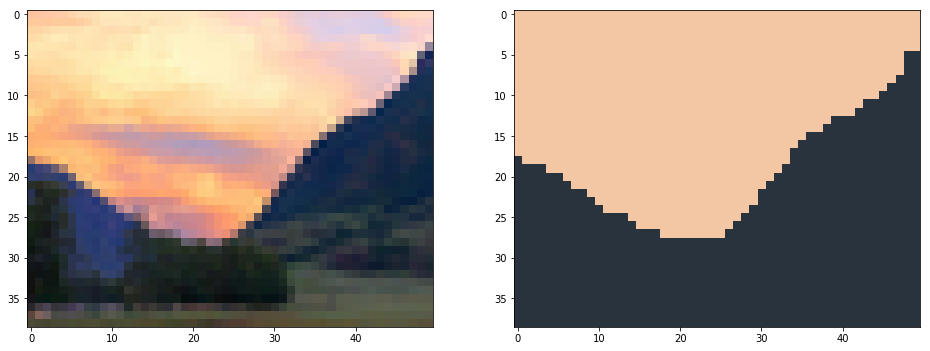

76987.93218383736

In [33]:
img = 'testimageCutted.jpg'
c = simple_get_centers(img)
process2_imgChangeResolution(img, cut_funcMinCut, c, True)

Поскольку у картинки очень большой размер, мне пришлось уменьшить разрешение, чтобы алгоритм, написанный вручную, сработал быстрее на моем компьютере